In [ ]:
# @title
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
# @title
from utils import *
from unet import *

In [ ]:
# @title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title
image_filenames_train = []

# creating a list of all files containing the word 'mask'
mask_files = glob('/content/drive/MyDrive/Data_LS/Images/*_mask*')

for i in mask_files:
    image_filenames_train.append(i.replace('_mask', ''))

print(image_filenames_train[:10])
len(image_filenames_train)

['/content/drive/MyDrive/Data_LS/Images/image(315).jpg', '/content/drive/MyDrive/Data_LS/Images/image(282).jpg', '/content/drive/MyDrive/Data_LS/Images/image(560).jpg', '/content/drive/MyDrive/Data_LS/Images/image(446).jpg', '/content/drive/MyDrive/Data_LS/Images/image(366).jpg', '/content/drive/MyDrive/Data_LS/Images/image(371).jpg', '/content/drive/MyDrive/Data_LS/Images/image(368).jpg', '/content/drive/MyDrive/Data_LS/Images/image(537).jpg', '/content/drive/MyDrive/Data_LS/Images/image(453).jpg', '/content/drive/MyDrive/Data_LS/Images/image(377).jpg']


1120

In [ ]:
# @title
print(mask_files[:10])
len(mask_files)

['/content/drive/MyDrive/Data_LS/Images/image(315)_mask.jpg', '/content/drive/MyDrive/Data_LS/Images/image(282)_mask.jpg', '/content/drive/MyDrive/Data_LS/Images/image(560)_mask.jpg', '/content/drive/MyDrive/Data_LS/Images/image(446)_mask.jpg', '/content/drive/MyDrive/Data_LS/Images/image(366)_mask.jpg', '/content/drive/MyDrive/Data_LS/Images/image(371)_mask.jpg', '/content/drive/MyDrive/Data_LS/Images/image(368)_mask.jpg', '/content/drive/MyDrive/Data_LS/Images/image(537)_mask.jpg', '/content/drive/MyDrive/Data_LS/Images/image(453)_mask.jpg', '/content/drive/MyDrive/Data_LS/Images/image(377)_mask.jpg']


1120

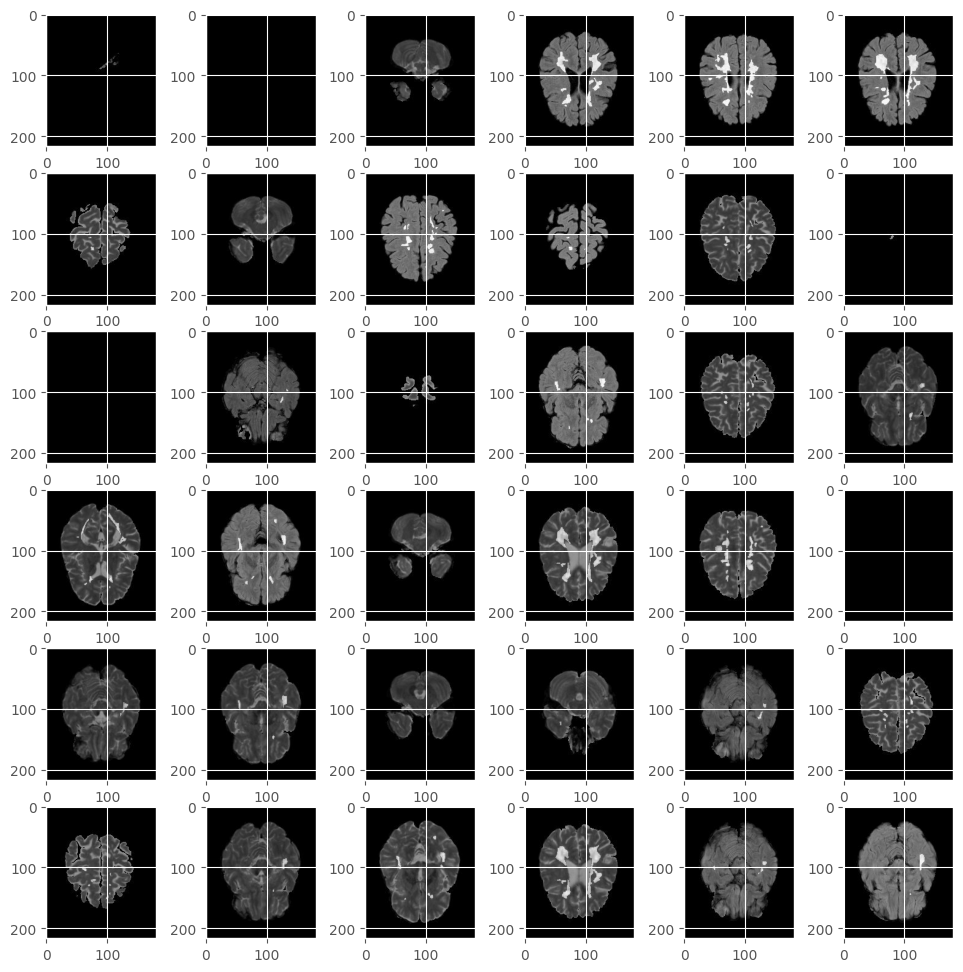

In [ ]:
# @title
plot_from_img_path(6, 6 , image_filenames_train, mask_files )

In [ ]:
# @title
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, 'mask': mask_files })

df_train, df_test = train_test_split(df, test_size=0.1)

# Further split this val and train
df_train, df_val = train_test_split(df_train, test_size=0.2)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(806, 2)
(112, 2)
(202, 2)


In [ ]:
# @title
df_train.describe()

,image_filenames_train,mask
count,806,806
unique,806,806
top,/content/drive/MyDrive/Data_LS/Images/image(55...,/content/drive/MyDrive/Data_LS/Images/image(55...
freq,1,1


In [ ]:
# @title
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

In [ ]:
# @title
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)

    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [ ]:
EPOCHS = 50
BATCH_SIZE =16
learning_rate = 1e-4
smooth=100

In [ ]:
# @title
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['activation[0][0]']          
                                                                                              

In [ ]:
im_width = 256
im_height = 256

In [ ]:
# @title
train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_param,
                                target_size=(im_height, im_width))

test_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

model = unet(input_size=(im_height, im_width, 3))



decay_rate = learning_rate / EPOCHS

opt = tf.keras.optimizers.legacy.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

#callbacks = [ModelCheckpoint('unet.hdf5', verbose=1, save_best_only=True)]
checkpointer=tf.keras.callbacks.ModelCheckpoint('model_lesions.hd5',verbose=1,save_best_only=True)
callbacks=tf.keras.callbacks.EarlyStopping(patience=4,monitor='val_loss'),tf.keras.callbacks.TensorBoard(log_dir='logs')

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data = test_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 806 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Found 806 validated image filenames.
Epoch 1/50
51/50 [==============================] - ETA: 0s - loss: -0.0331 - binary_accuracy: 0.8415 - iou: 0.0177 - dice_coefficients: 0.0340Found 202 validated image filenames.
Found 202 validated image filenames.
50/50 [==============================] - 105s 1s/step - loss: -0.0331 - binary_accuracy: 0.8415 - iou: 0.0177 - dice_coefficients: 0.0340 - val_loss: -0.0087 - val_binary_accuracy: 0.8621 - val_iou: 0.0044 - val_dice_coefficients: 0.0085
Epoch 2/50
50/50 [==============================] - 40s 799ms/step - loss: -0.0650 - binary_accuracy: 0.9640 - iou: 0.0346 - dice_coefficients: 0.0656 - val_loss: -0.0103 - val_binary_accuracy: 0.9945 - val_iou: 0.0053 - val_dice_coefficients: 0.0102
Epoch 3/50
50/50 [==============================] - 42s 826ms/step - loss: -0.0834 - binary_accuracy: 0.9761 - iou: 0.0458 - dice_coefficients: 0.0856 - val_loss: -0.0110 - val_binary_accuracy: 0.9963 - val_iou: 0.0058 - val_dice_coefficients: 0.0111
Epoch 

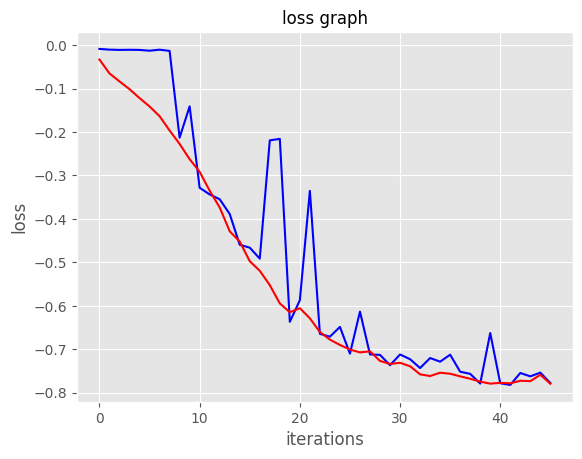

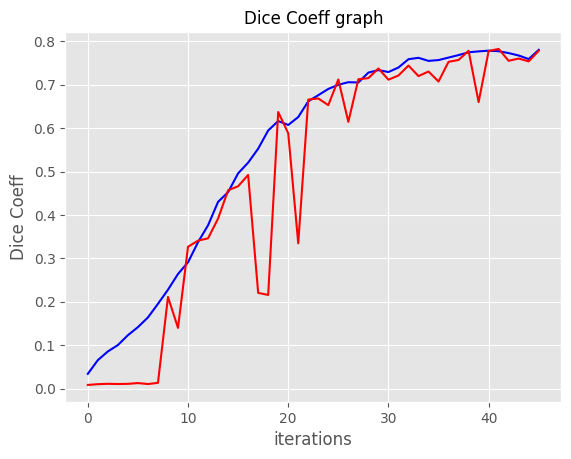

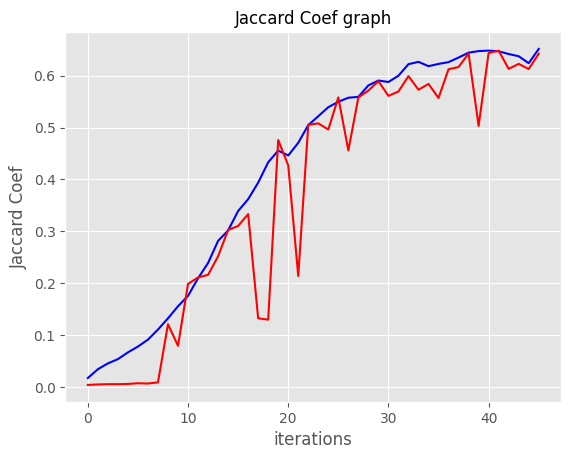

In [ ]:
# @title
history_post_training = history.history
train_dice_coeff_list = history_post_training['dice_coefficients']
test_dice_coeff_list = history_post_training['val_dice_coefficients']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list, 'r-')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)

plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(test_dice_coeff_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('Dice Coeff')
plt.title('Dice Coeff graph', fontsize=12)
plt.show()

plt.figure(3)
plt.plot(train_jaccard_list, 'b-')
plt.plot(test_jaccard_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('Jaccard Coef')
plt.title('Jaccard Coef graph', fontsize=12)
plt.show()

1/1 [==============================] - 3s 3s/step


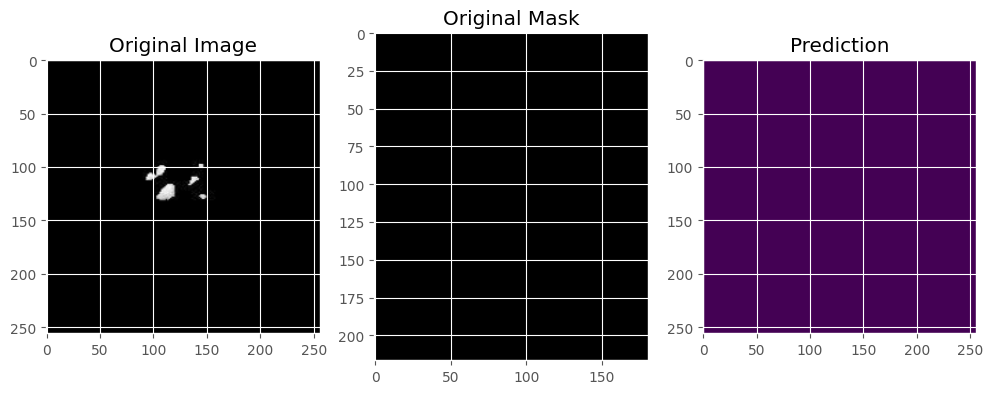

1/1 [==============================] - 0s 27ms/step


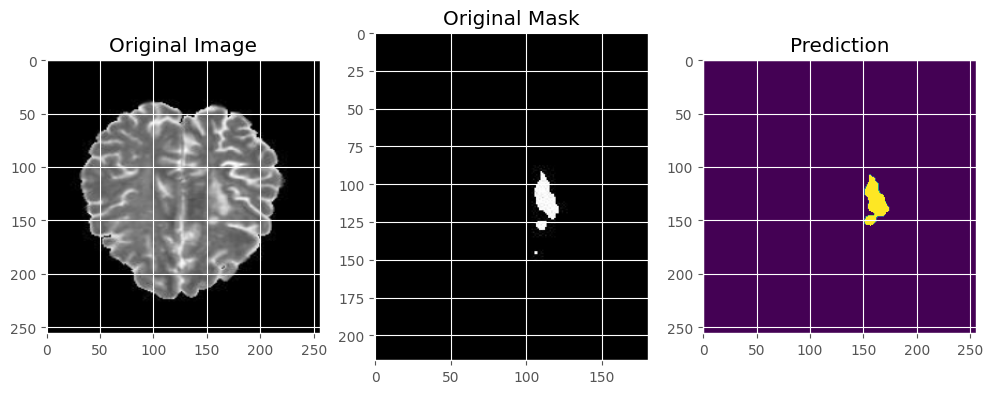

1/1 [==============================] - 0s 33ms/step


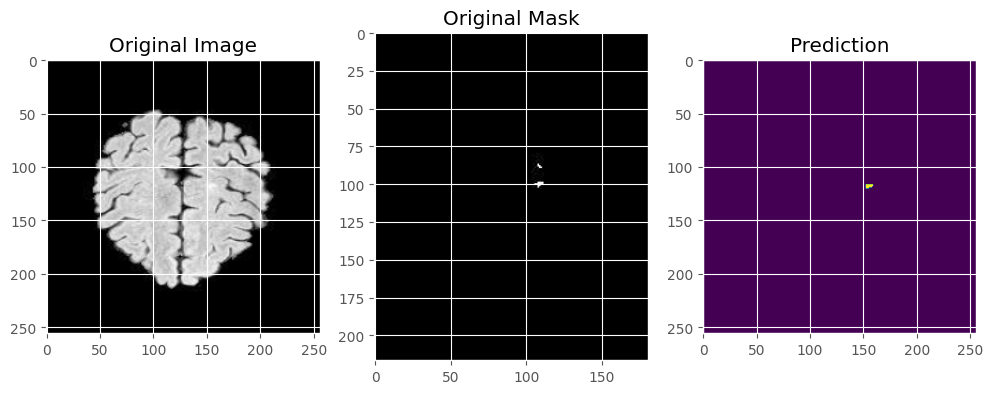

1/1 [==============================] - 0s 34ms/step


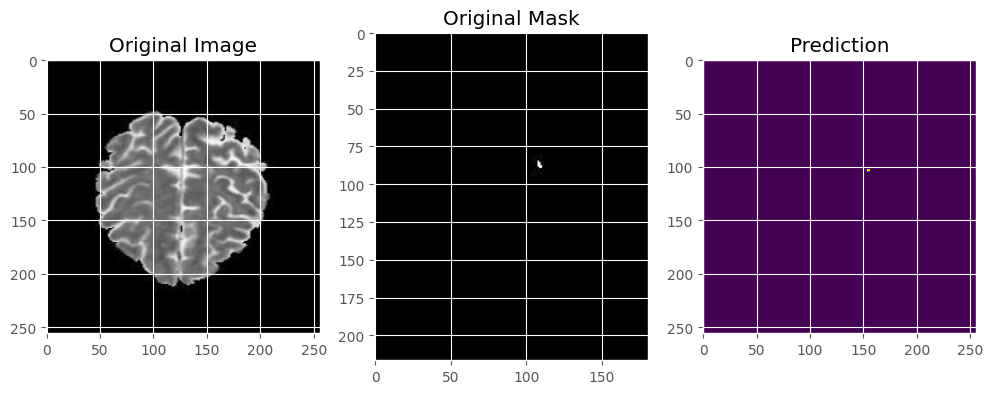

1/1 [==============================] - 0s 39ms/step


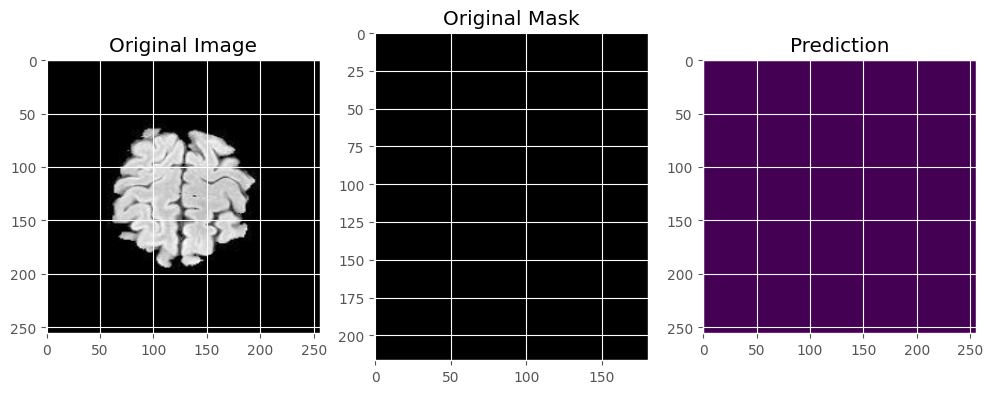

1/1 [==============================] - 0s 19ms/step


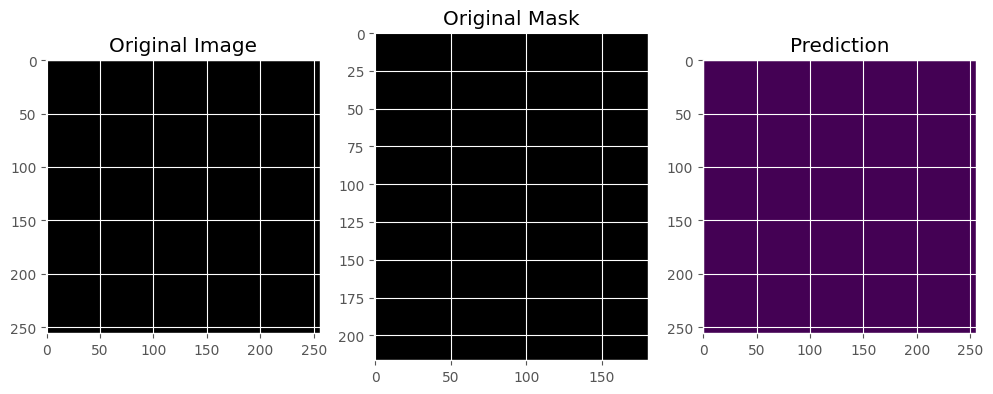

1/1 [==============================] - 0s 20ms/step


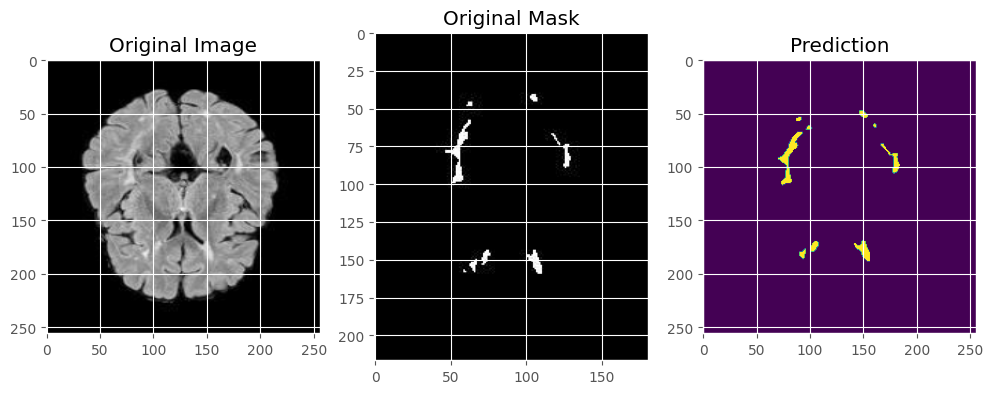

1/1 [==============================] - 0s 19ms/step


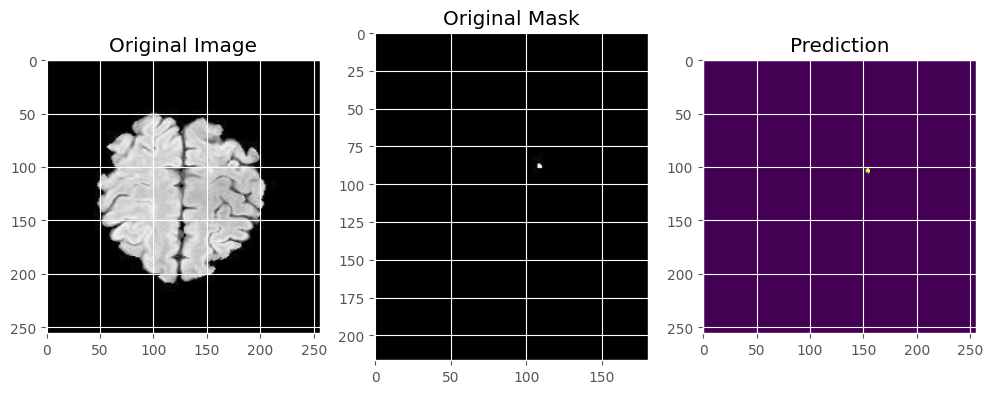

1/1 [==============================] - 0s 20ms/step


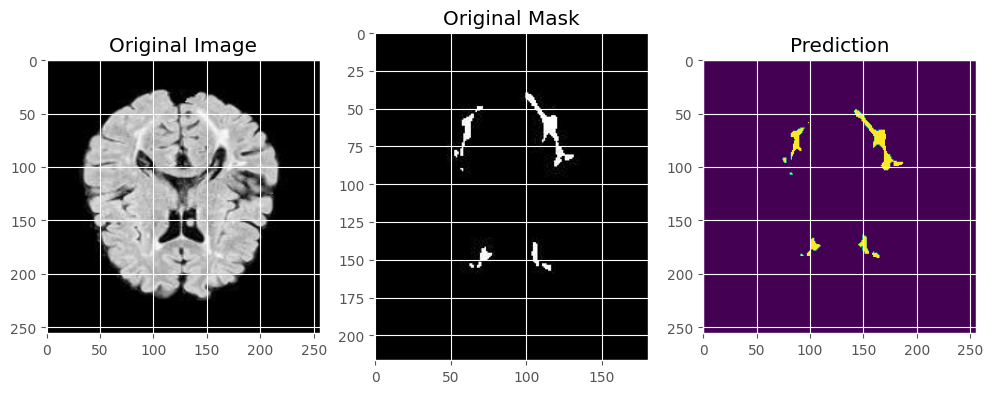

1/1 [==============================] - 0s 23ms/step


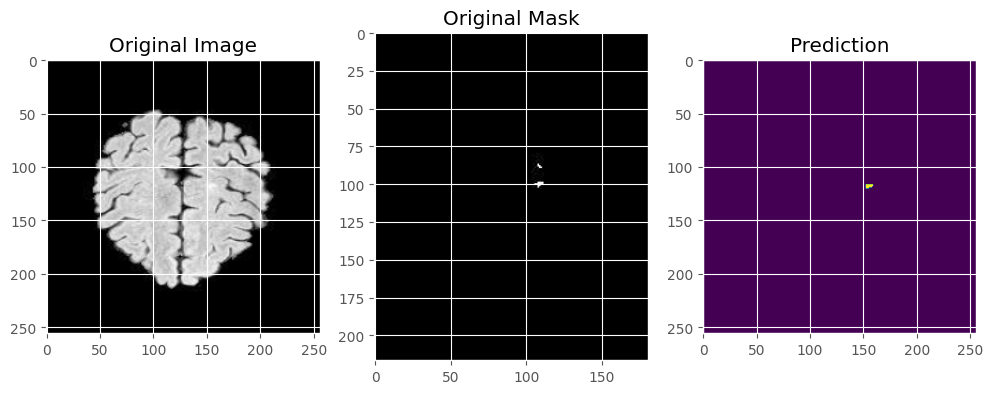

1/1 [==============================] - 0s 19ms/step


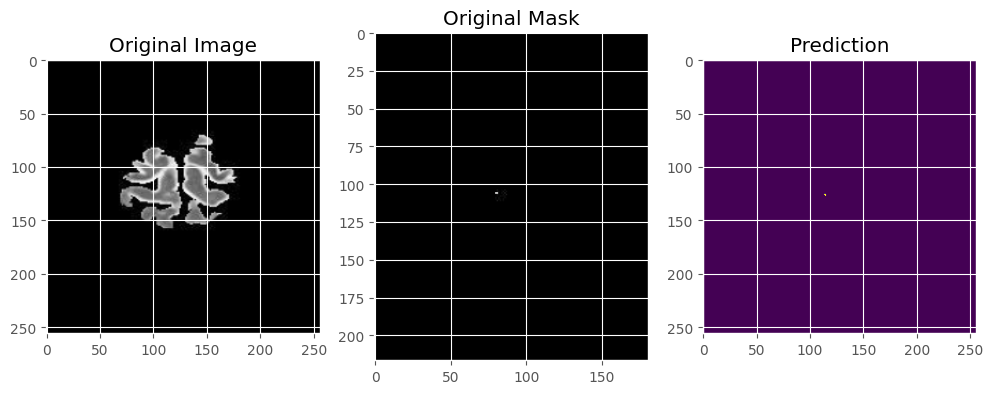

1/1 [==============================] - 0s 19ms/step


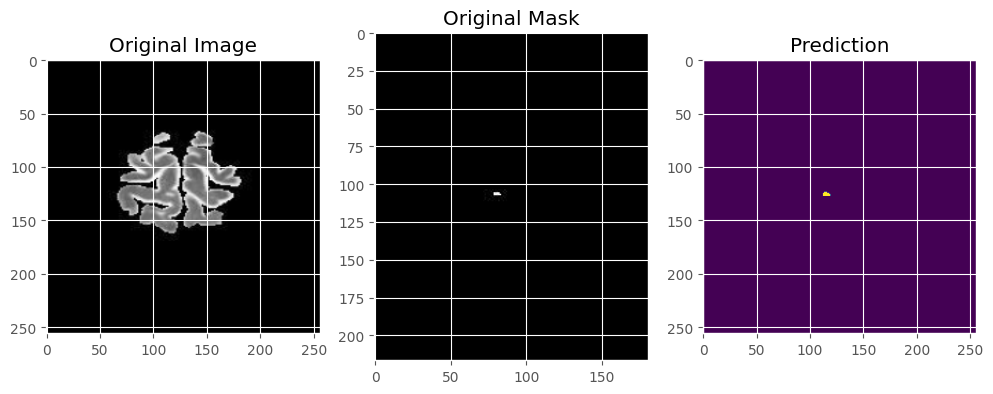

1/1 [==============================] - 0s 21ms/step


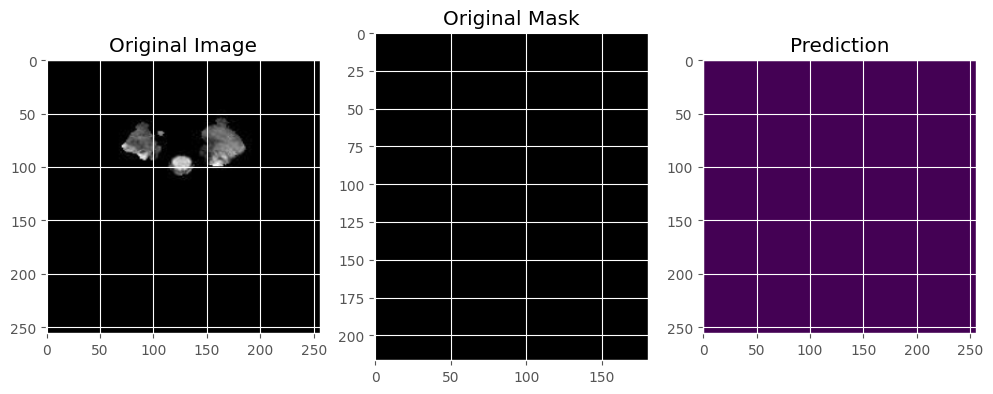

1/1 [==============================] - 0s 19ms/step


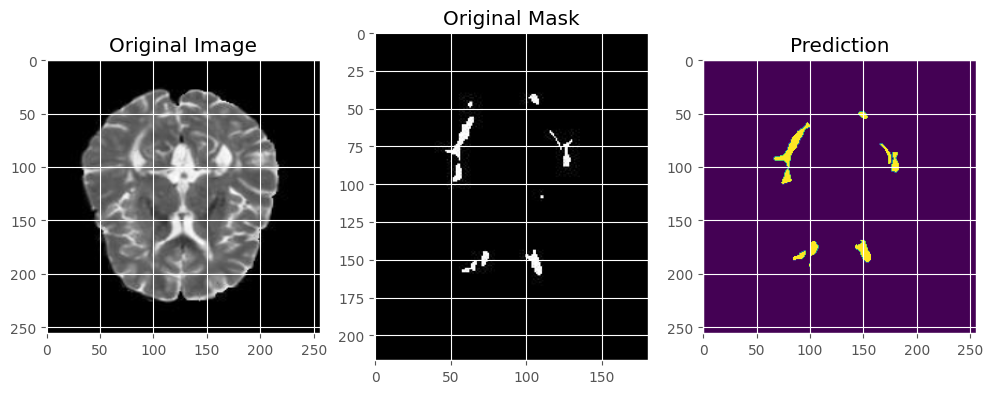

1/1 [==============================] - 0s 20ms/step


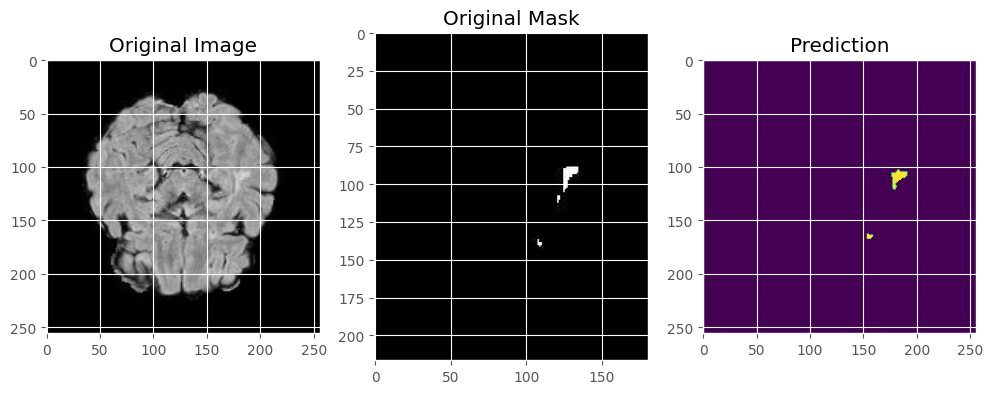

1/1 [==============================] - 0s 19ms/step


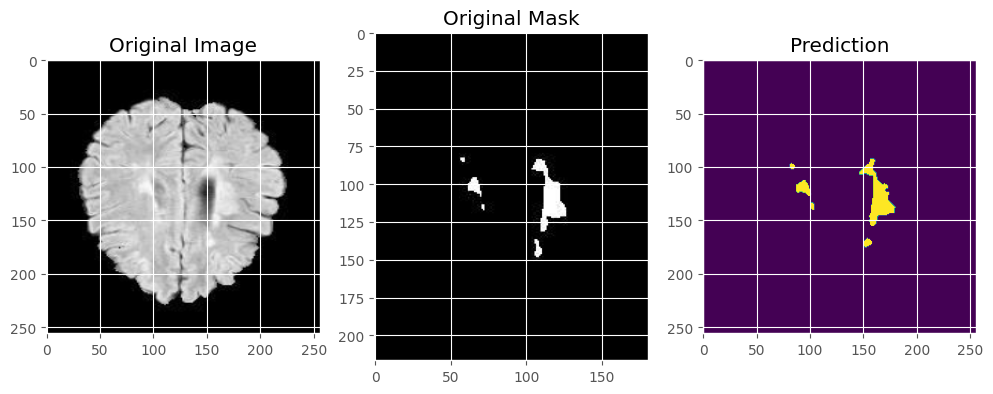

1/1 [==============================] - 0s 19ms/step


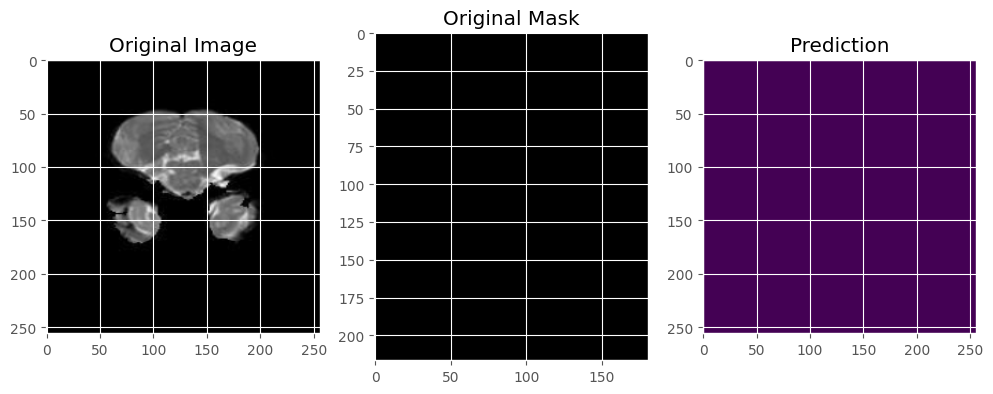

1/1 [==============================] - 0s 22ms/step


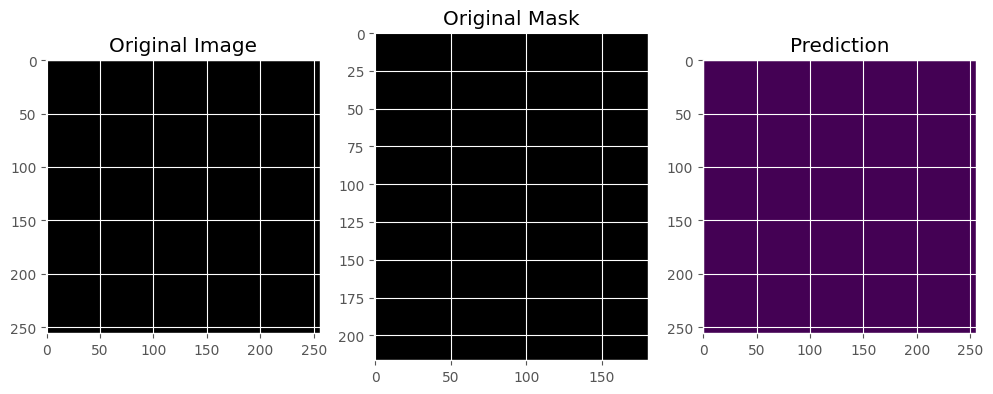

1/1 [==============================] - 0s 22ms/step


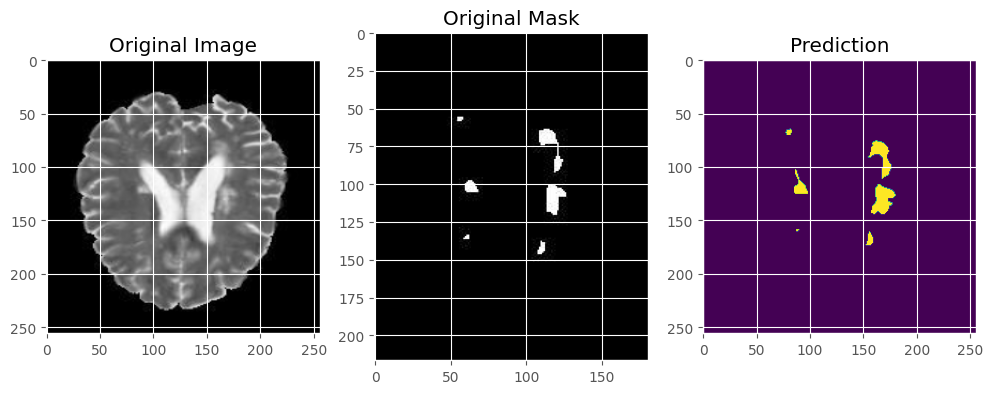

1/1 [==============================] - 0s 18ms/step


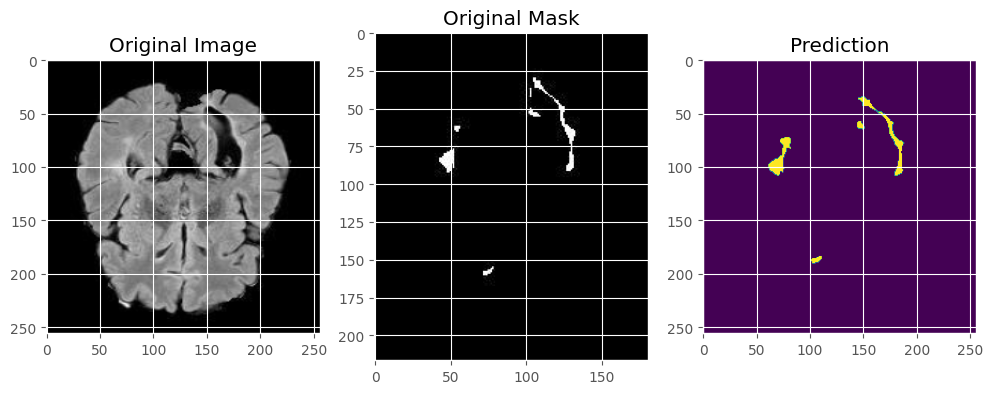

In [ ]:
for i in range(20):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.resize(img, (im_height, im_width))
    img = img/255
    # print(imgs.shape) (256, 256 , 3)
    img = img[np.newaxis, :, :, : ]
    # print(img.shape) # (1, 256, 256, 3)

    predicted_img = model.predict(img)

    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.show()